# AE567 State Estimation and Learning
## Guide: Prof. Alex Gorotodesky

## Project 2a: Code: Soham Shirish Phanse

# Routine Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.linalg import cholesky, cho_solve, solve_triangular
from scipy.optimize import minimize

# interactive imports
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

# Gaussian Process Regression - Implementation from Scratch

In [2]:
def normalize_scent_strength(scent_strength):
    return (scent_strength - np.mean(scent_strength)) / np.std(scent_strength)

In [3]:
def min_max_normalize(scent_strength):
    return (scent_strength - np.min(scent_strength)) / (np.max(scent_strength) - np.min(scent_strength))

In [4]:
# Define RBF Kernel
def rbf_kernel(X1, X2, length_scale):

    # computes the Radial basis function kernel value

    ## compute euclidnean distance between X1 and X2
    dists = np.sum((X1[:, np.newaxis, :] - X2[np.newaxis, :, :])**2, axis=-1)

    return np.exp(-0.5 * dists / length_scale**2)

# Define Constant Kernel
def constant_kernel(X1, X2, constant_value):

    # computes the constant kernel function value
    return constant_value * np.ones((X1.shape[0], X2.shape[0]))

# Define Kernel Combination
def combined_kernel(X1, X2, length_scale, constant_value):

    # computes the combined kernel function value

    # find product of btoth kernsles and return value
    return rbf_kernel(X1, X2, length_scale) + constant_kernel(X1, X2, constant_value)

In [5]:
# Log Marginal Likelihood
def log_marginal_likelihood(params, X_train, y_train, noise_var=1e-10):

    # Compute log marginal likelihood with fixed noise variance

    # compute likelihood for data
    length_scale, constant_value = params
    K = combined_kernel(X_train, X_train, length_scale, constant_value)
    K += np.eye(len(X_train)) * noise_var  # add small noise to diagonal elements for numerical stability

    try:
        L = cholesky(K, lower=True)
    except np.linalg.LinAlgError:
        return np.inf  # Penalize if the decomposition fails

    # solve for dual problem parameters
    alpha = cho_solve((L, True), y_train)

    # now compute marginal likelihood (or termed as evidence), i.e probability of observed data given the parameters
    log_likelihood = -0.5 * np.dot(y_train.T, alpha) - np.sum(np.log(np.diag(L))) - 0.5 * len(X_train) * np.log(2 * np.pi)


    # since we want to minimize log_likelihood, return negative value
    return -log_likelihood

# training or fitting function for GPR
def train_gpr_2(X_train, y_train, bounds, initial_params=(1.0, 1.0)):

    noise_var = 1e-10  # declare fixed variance value to add

    # minimize log marginal likelihood with respect to kernel hyperparameters
    result = minimize(log_marginal_likelihood, initial_params, args=(X_train, y_train, noise_var), bounds=bounds, method="L-BFGS-B")

    result_success, result_x = result.success, result.x

    if not result_success:
        raise RuntimeError(f"Optimization failed: {result.message}")

    length_scale, constant_value = result_x

    print(f"Optimized Parameters: length_scale (for RBF)={length_scale}, constant_value (for Constant kernel)= {constant_value}")

    # compute new kernel with optimized parameters and add noise
    K = combined_kernel(X_train, X_train, length_scale, constant_value)
    K += np.eye(len(X_train)) * noise_var

    # perform cholesky decomposition and solve for L
    L = cholesky(K, lower=True)
    alpha = cho_solve((L, True), y_train)

    # return optimized parameters
    return alpha, L, X_train, y_train, (length_scale, constant_value, noise_var)

In [6]:
# Prediction Function
def predict_gpr_2(X_test, X_train, y_train, alpha, L, optimized_params):

    # we perform predictions using the optimized GPR parameters
    length_scale, constant_value, noise_var = optimized_params

    # compute similarity between test inputs and train inputs
    Kt = combined_kernel(X_test, X_train, length_scale, constant_value)

    # compte similarity matrix with self
    Ks = combined_kernel(X_test, X_test, length_scale, constant_value) + np.eye(len(X_test)) * noise_var

    # take dot product with unknown regression parameters obtained fmor training phase
    y_pred = np.dot(Kt, alpha)

    # solve the triangular system
    v = solve_triangular(L, Kt.T, lower=True)

    # compute co variance
    y_cov = Ks - np.dot(v.T, v)
    y_std = np.sqrt(np.diag(y_cov))

    # return predictions, covariances and standard deviations
    return y_pred, y_cov, y_std

# Given Data

In [7]:
# Initial data
X_init = np.array([[0.1, 0.05], [-0.9, 0.3], [0.2, 0.4], [0.8, -0.3],
                   [-0.6, 0.3], [0.3, -0.2], [0.5, -0.84], [-0.5, 0.85],
                   [-0.01, -0.76], [-0.9, -0.9]])

X_req1 = np.array([[0.1, 0.05], [-0.9, 0.3], [0.2, 0.4], [0.8, -0.3],
                   [-0.6, 0.3], [0.3, -0.2], [0.5, -0.84], [-0.5, 0.85],
                   [-0.01, -0.76], [-0.9, -0.9], [-0.33, -1.0], [-0.555, -0.555], [-0.777, 1.0], [0.555, 1.0]])

X_req2 = np.array([[0.1, 0.05], [-0.9, 0.3], [0.2, 0.4], [0.8, -0.3],
                   [-0.6, 0.3], [0.3, -0.2], [0.5, -0.84], [-0.5, 0.85],
                   [-0.01, -0.76], [-0.9, -0.9], [-0.33, -1.0], [-0.555, -0.555], [-0.777, 1.0], [0.555, 1.0], [0.26315, 0.8947], [-1.0, -0.78947], [-0.684, 0.789]])
# can add at last is instability can be removed: [-0.789, 0.8947]

X_req3 = np.array([[0.1, 0.05], [-0.9, 0.3], [0.2, 0.4], [0.8, -0.3],
                   [-0.6, 0.3], [0.3, -0.2], [0.5, -0.84], [-0.5, 0.85],
                   [-0.01, -0.76], [-0.9, -0.9],
                    [-0.33, -1.0], [-0.555, -0.555], [-0.777, 1.0], [0.555, 1.0],
                    [0.26315, 0.8947], [-1.0, -0.78947], [-0.684, 0.789],
                    [0.65, 0.4], [-0.7, -0.1], [-0.1, -0.3], [-0.25, 0.6]])
# can add at last if instability can be removed; [-0.789, 0.8947]

y_init = np.array([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623,
                   2.99495501, 3.94274928, 2.7968011, 3.34929734, 3.91296165])

y_req1 = np.array([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623,
                   2.99495501, 3.94274928, 2.7968011, 3.34929734, 3.91296165,
                   3.66721001, 3.30720252, 3.0361246, 3.1213285])

y_req2 = np.array([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623,
                   2.99495501, 3.94274928, 2.7968011, 3.34929734, 3.91296165,
                   3.66721001, 3.30720252, 3.0361246, 3.1213285,
                   2.6251822, 4.13799681, 3.197143])

y_req3 = np.array([3.39382006, 3.2073034, 3.39965035, 3.68810201, 2.96941623,
                   2.99495501, 3.94274928, 2.7968011, 3.34929734, 3.91296165,
                   3.66721001, 3.30720252, 3.0361246, 3.1213285,
                   2.6251822, 4.13799681, 3.197143,
                   3.2759354, 4.2120750, 3.19261195, 4.27795864])


# normalize the scent strength values with standard normal
y_init_normal = normalize_scent_strength(y_init)
y_req1_normal = normalize_scent_strength(y_req1)
y_req2_normal = normalize_scent_strength(y_req2)
y_req3_normal = normalize_scent_strength(y_req3)

# Visualize Data

## 3D scatter plots

In [8]:
def initial_visualization(X_arr, y_arr, titles):
  Xlen, ylen = len(X_arr), len(y_arr)

  fig1, ax = plt.subplots(1, Xlen, figsize=(16, 8), subplot_kw={'projection': '3d'})
  for i in range(Xlen):
    ax[i].scatter(X_arr[i][:, 0], X_arr[i][:, 1], y_arr[i])
    ax[i].set_xlabel(r'$X \longrightarrow$')
    ax[i].set_ylabel(r'$Y \longrightarrow$')
    ax[i].set_zlabel(r'Scent Strength: $\longrightarrow$')
    ax[i].set_xticks([-1, -0.5, 0, 0.5, 1])
    ax[i].set_yticks([-1, -0.5, 0, 0.5, 1])
    ax[i].set_title(titles[i])

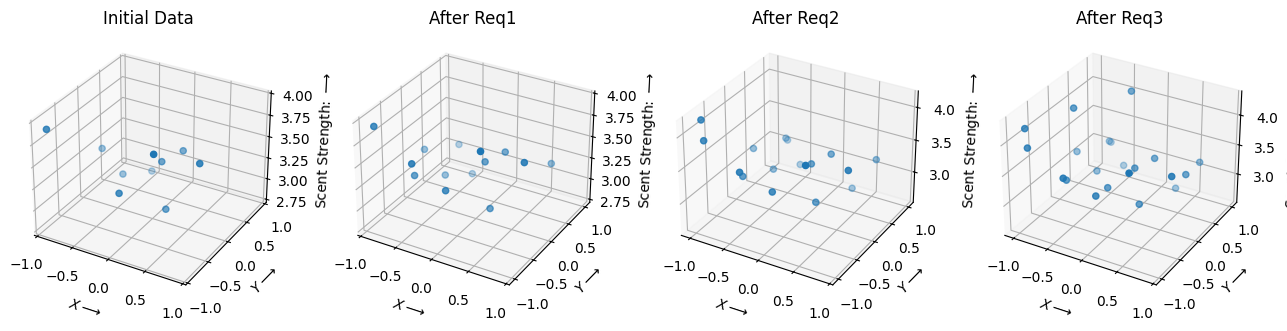

In [9]:
initial_visualization(list([X_init, X_req1, X_req2, X_req3]), list([y_init, y_req1, y_req2, y_req3]), titles=['Initial Data', 'After Req1', 'After Req2', 'After Req3'])

## Linear Interpolation based Visualization

In [10]:
def linear_interpolation_visualization(Xarr, yarr, titles, nx=500, ny=500):

  Xlen, ylen = len(Xarr), len(yarr)

  fig2, ax = plt.subplots(1, Xlen, figsize=(24, 4))
  for i in range(Xlen):
   X, y = Xarr[i], yarr[i]

   # Create a grid of points for interpolation
   xlin = np.linspace(X[:, 0].min(), X[:, 0].max(), nx)
   ylin = np.linspace(X_init[:, 1].min(), X_init[:, 1].max(), ny)
   grid_xlin, grid_ylin = np.meshgrid(xlin, ylin)

   # Interpolate the surface using linear interpolation
   grid_z0_lin = griddata(X, y, (grid_xlin, grid_ylin), method='linear')

   # Plot the contour
   contour_lin = ax[i].contour(grid_xlin, grid_ylin, grid_z0_lin, levels=20, cmap='viridis')
   ax[i].clabel(contour_lin, inline=True, fontsize=8)
   ax[i].set_xlabel(r'$X \longrightarrow$')
   ax[i].set_ylabel(r'$Y \longrightarrow$')

   fig2.colorbar(contour_lin, ax=ax[i], label='Normalized Scent Strength')
   ax[i].set_xticks([-1, -0.5, 0, 0.5, 1])
   ax[i].set_yticks([-1, -0.5, 0, 0.5, 1])
   ax[i].set_title(titles[i])

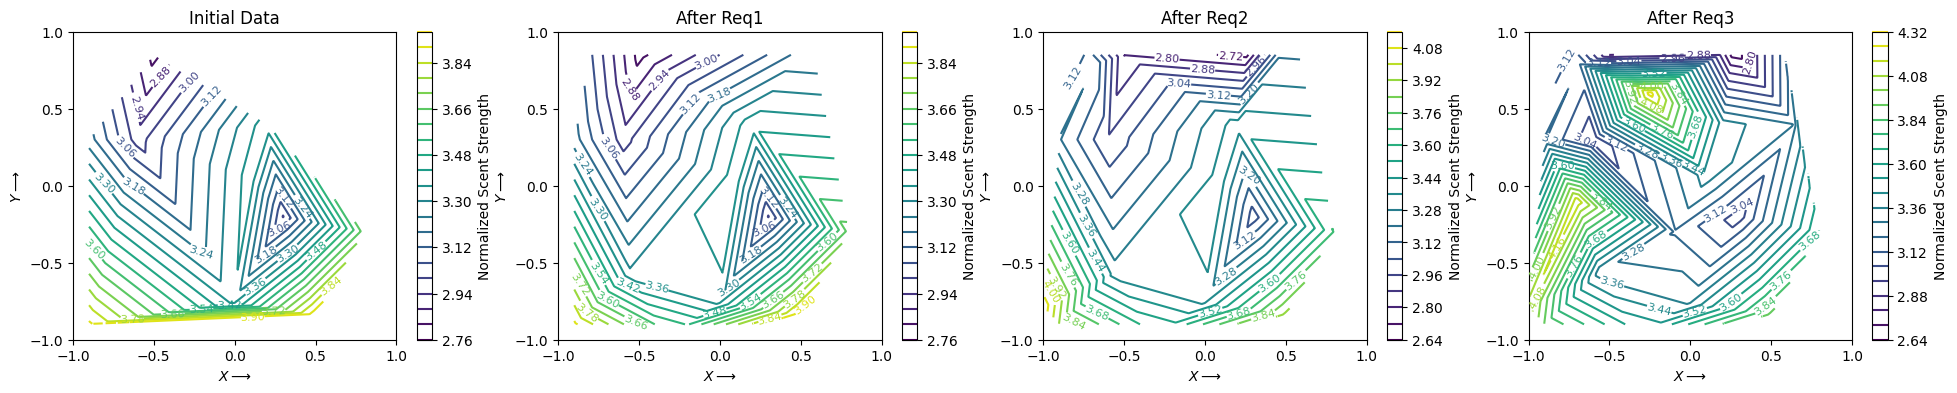

In [11]:
linear_interpolation_visualization(list([X_init, X_req1, X_req2, X_req3]), list([y_init, y_req1, y_req2, y_req3]), titles=['Initial Data', 'After Req1', 'After Req2', 'After Req3'])

# Decision Making Using Gaussian process regression

In [12]:
def compute_gpr(X, y, bounds, initial_params, prediction_grid_params):

  alpha, L, X_train, y_train, opt_params = train_gpr_2(X, y, bounds, initial_params)

  gx, gy = prediction_grid_params[0], prediction_grid_params[1]
  xgpr, ygpr = np.linspace(-1, 1, gx), np.linspace(-1, 1, gy)
  X_grid = np.array([[i, j] for i in xgpr for j in ygpr])

  # make the predictions
  y_pred, y_cov, y_std = predict_gpr_2(X_grid, X_train, y_train, alpha, L, opt_params)

  # reshape for potting
  y_pred = y_pred.reshape(gx, gy)
  y_std = y_std.reshape(gx, gy)

  # compute the location where scnet value is maximum
  max_index_initial = np.unravel_index(np.argmax(y_pred), y_pred.shape)

  # get the corresponding x and y values
  max_index_initial_x, max_index_initial_y = xgpr[max_index_initial[1]], ygpr[max_index_initial[0]]

  return xgpr, ygpr, X_grid, y_pred, y_cov, y_std, max_index_initial_x, max_index_initial_y

In [13]:
def plot_gpr(xgpr, ygpr, X, ypred, sigma, scatter_label, title="blank"):

  # create a figure with 2 subplots side by side
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

  # plot the mean on the left subplot
  im1 = ax1.contourf(xgpr, ygpr, ypred, cmap='viridis')
  ax1.set_xlabel(r'$X \longrightarrow$')
  ax1.set_ylabel(r'$Y \longrightarrow$')
  if title=="blank":
    ax1.set_title(r'Predicted Scent Strength Mean: Kernel: $\sigma^2_f exp(-\frac{1}{2l^2}|\bar{x}_p - \bar{x}_q|^2)$', size=10)
  else:
    ax1.set_title(title, size=10)
  ax1.scatter(X[:, 0], X[:, 1], marker='x', color='red', s=35, label=scatter_label)
  fig.colorbar(im1, ax=ax1, label='Predicted Scent Strength')
  ax1.legend()

  # Plot the variance on the right subplot
  im2 = ax2.contourf(xgpr, ygpr, sigma, cmap='viridis')
  ax2.set_xlabel(r'$X \longrightarrow$')
  ax2.set_ylabel(r'$Y \longrightarrow$')
  if title=="blank":
    ax2.set_title(r'Predicted Scent Strength Variance: Kernel: $\sigma^2_f exp(-\frac{1}{2l^2}|\bar{x}_p - \bar{x}_q|^2)$', size=10)
  else:
    ax2.set_title(title, size=10)
  ax2.scatter(X[:, 0], X[:, 1], marker='x', color='red', s=35, label=scatter_label)
  fig.colorbar(im2, ax=ax2, label='Predicted Variance')
  ax2.legend()

  return fig, (ax1, ax2)

Optimized Parameters: length_scale (for RBF)=0.2610008277028157, constant_value (for Constant kernel)= 1e-05


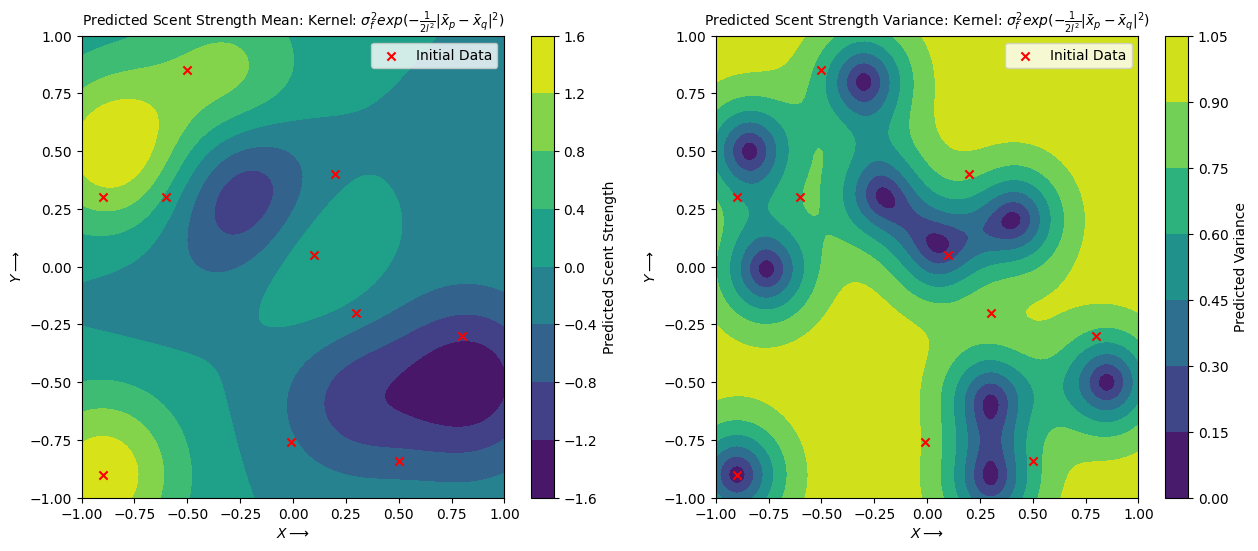

In [14]:
initial_params_init = (1.0, 1.0)
bounds_init = [(1e-5, None), (1e-5, None)]
prediction_grid_params = (100, 100)

xgprinit, ygprinit, X_gridinit, y_predinit, y_covinit, y_stdinit, max_index_initial_xinit, max_index_initial_yinit = compute_gpr(X_init, y_init_normal, bounds_init, initial_params_init, prediction_grid_params)

init_fig, init_axes = plot_gpr(xgprinit, ygprinit, X_init, y_predinit, y_stdinit, "Initial Data")

Optimized Parameters: length_scale (for RBF)=0.27748827986639135, constant_value (for Constant kernel)= 1e-05


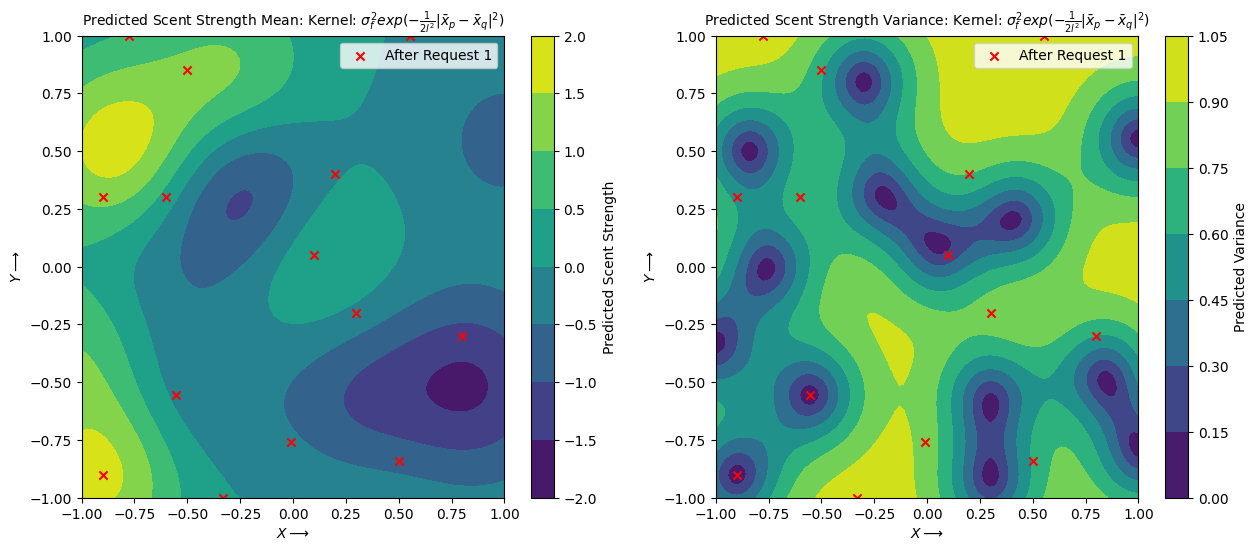

In [15]:
initial_params_req1 = (1.0, 1.0)
bounds_req1 = [(1e-5, None), (1e-5, None)]
prediction_grid_params = (100, 100)

xgprreq1, ygprreq1, X_gridreq1, y_predreq1, y_covreq1, y_stdreq1, max_index_initial_xreq1, max_index_initial_yreq1 = compute_gpr(X_req1, y_req1_normal, bounds_req1, initial_params_req1, prediction_grid_params)

req1_fig, req1_axes = plot_gpr(xgprreq1, ygprreq1, X_req1, y_predreq1, y_stdreq1, "After Request 1")

Optimized Parameters: length_scale (for RBF)=0.2288223973222807, constant_value (for Constant kernel)= 1e-05


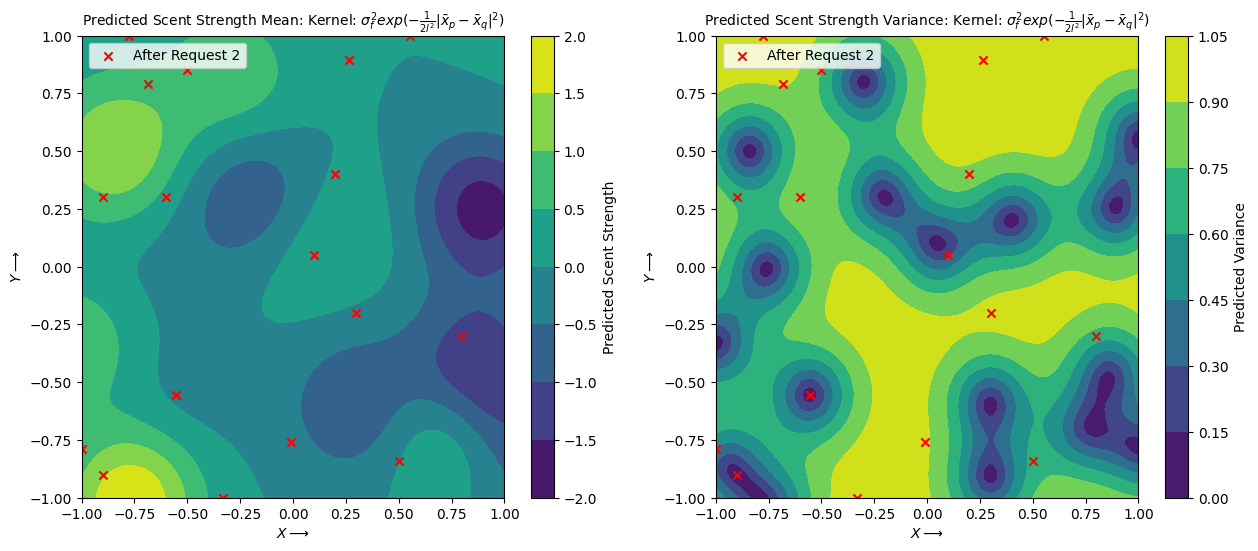

In [16]:
initial_params_req2 = (1.0, 1.0)
bounds_req2 = [(1e-5, None), (1e-5, None)]
prediction_grid_params = (100, 100)

xgprreq2, ygprreq2, X_gridreq2, y_predreq2, y_covreq2, y_stdreq2, max_index_initial_xreq2, max_index_initial_yreq2 = compute_gpr(X_req2, y_req2_normal, bounds_req2, initial_params_req2, prediction_grid_params)

req2_fig, req2_axes = plot_gpr(xgprreq2, ygprreq2, X_req2, y_predreq2, y_stdreq2, "After Request 2")

Optimized Parameters: length_scale (for RBF)=0.15670428447272397, constant_value (for Constant kernel)= 1e-05


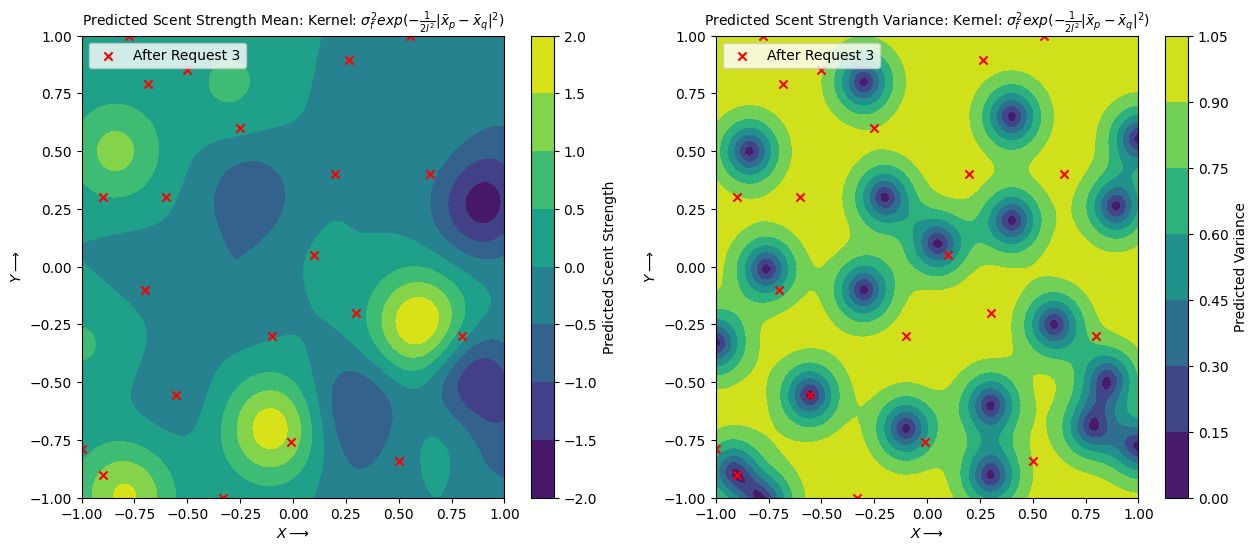

In [17]:
initial_params_req3 = (1.0, 1.0)
bounds_req3 = [(1e-5, None), (1e-5, None)]
prediction_grid_params = (100, 100)

xgprreq3, ygprreq3, X_gridreq3, y_predreq3, y_covreq3, y_stdreq3, max_index_initial_xreq3, max_index_initial_yreq3 = compute_gpr(X_req3, y_req3_normal, bounds_req3, initial_params_req3, prediction_grid_params)

req3_fig, req3_axes = plot_gpr(xgprreq3, ygprreq3, X_req3, y_predreq3, y_stdreq3, "After Request 3")

# Upper Confidence Bounds based Sampling Strategy

In [18]:
from IPython.display import clear_output

In [19]:
def UCB_picker(X, y, bounds, initial_params, prediction_grid_params, c, n_samples, scatter_label, every_k_sample):

  clear_output(wait=True)

  xgpr, ygpr, X_grid, y_pred, y_cov, y_std, max_index_initial_x, max_index_initial_y = compute_gpr(X, y, bounds, initial_params, prediction_grid_params)

  UB = y_pred + c*y_std
  UB_flat = UB.flatten()
  top_values = np.sort(UB_flat)[::-1][:n_samples*every_k_sample]

  # Remove duplicates while keeping the order intact
  unique_top_values = np.unique(top_values)

  # make sure that still n_samples are selected, if less add more samples
  counter = n_samples*every_k_sample
  while len(unique_top_values) < n_samples:
    # add the next top value to unique_top_values
    next_top_value = np.sort(UB_flat)[::-1][counter]
    unique_top_values = np.append(unique_top_values, next_top_value)
    unique_top_values = np.unique(unique_top_values)
    counter += 1

  # select alternate values
  top_values = unique_top_values[::every_k_sample]
  top_values = top_values[:n_samples]

  # find indices of top_values in UB_flat
  top_indices = np.array(np.where(np.isin(UB_flat, top_values)))

  # remove duplicates from top_indices as well
  top_indices = top_indices[:n_samples]

  # find the corresponding points in the grid
  best_points = X_grid[top_indices].reshape(n_samples, 2)

  # plot the gaussian contour and mark the points with crosses
  # Create a figure with two subplots side by side
  fig, (ax1, ax2) = plot_gpr(xgpr, ygpr, X, y_pred, y_std, scatter_label, "blank")

  # Plot the mean on the left subplot
  ax1.scatter(best_points[:, 1], best_points[:, 0], marker='x', color='black', s=35, label='New Samples')
  ax1.legend()

  # Plot the variance on the right subplot
  ax2.scatter(best_points[:, 1], best_points[:, 0], marker='x', color='black', s=35, label='New Samples')
  ax2.legend()

  plt.show()

  return best_points#, top_indices, UB

# Define a function to wrap around UCB_picker and use the slider for 'c'
def UCB_interactive(X, y, bounds, initial_params, prediction_grid_params, c, n_samples, scatter_label, every_k_sample):
    return UCB_picker(X, y, bounds, initial_params, prediction_grid_params, c, n_samples, scatter_label, every_k_sample)


# Create an interaction
interact(UCB_interactive,
         X=widgets.fixed(X_req2),
         y = widgets.fixed(y_req2_normal),
         bounds = widgets.fixed([(1e-5, None), (1e-5, None)]),
         initial_params = widgets.fixed([1.0, 1.0]),
         prediction_grid_params=widgets.fixed([20, 20]),
         c = widgets.FloatSlider(min=0.0, max=10.0, step=0.01, value=1.0), n_samples=widgets.IntSlider(min=1, max=4, step=1, value=2),
         scatter_label=widgets.fixed('UCB Selection: Request 2'),
         every_k_sample = widgets.IntSlider(min=1, max=10, step=1, value=3))

interactive(children=(FloatSlider(value=1.0, description='c', max=10.0, step=0.01), IntSlider(value=2, descrip…

<function __main__.UCB_interactive(X, y, bounds, initial_params, prediction_grid_params, c, n_samples, scatter_label, every_k_sample)>

# Non-normalized Strength Function

In [20]:
def non_normalized_scent_strength(mu, sigma, y_req):

  mu_nn = mu*np.std(y_req) + np.mean(y_req)
  sigma_nn = sigma*np.std(y_req)

  new_params = np.array([mu_nn, sigma_nn])

  return new_params

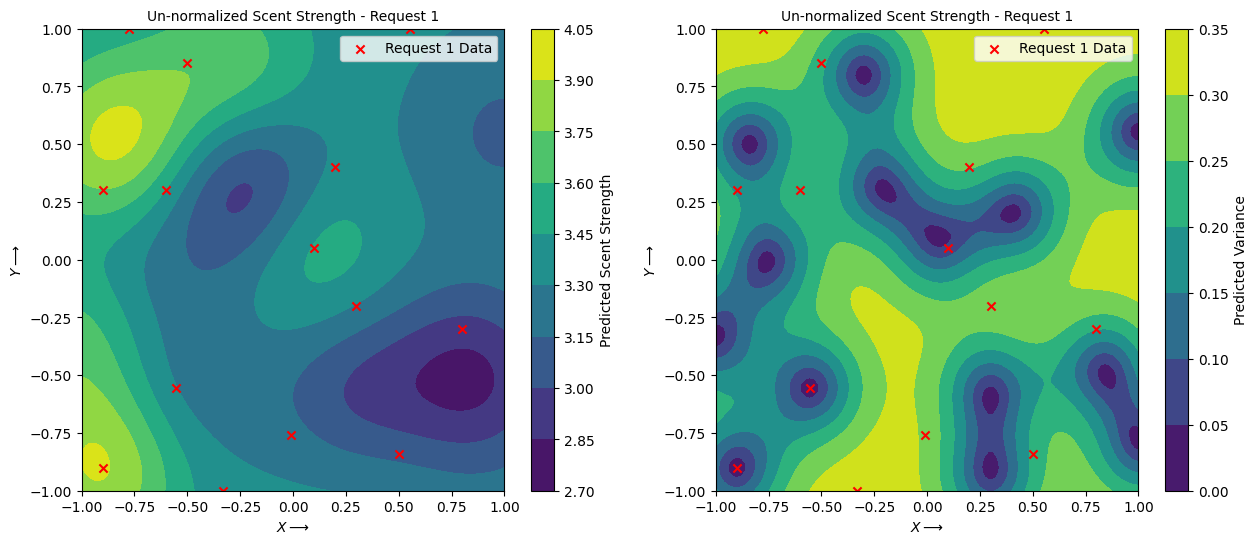

In [21]:
# after sampling request 1
S_req1 = non_normalized_scent_strength(y_predreq1, y_stdreq1, y_req1)

fig_req1, req1_axes = plot_gpr(xgprreq1, ygprreq1, X_req1, S_req1[0], S_req1[1], "Request 1 Data", "Un-normalized Scent Strength - Request 1")

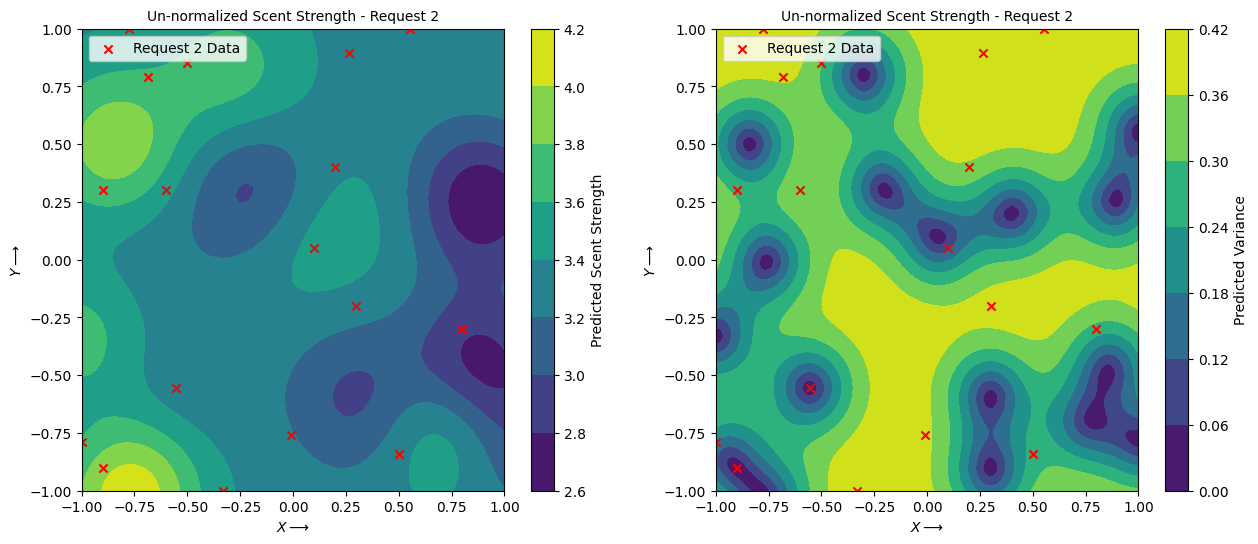

In [22]:
# after sampling request 1
S_req2 = non_normalized_scent_strength(y_predreq2, y_stdreq2, y_req2)

fig_req2, req2_axes = plot_gpr(xgprreq2, ygprreq2, X_req2, S_req2[0], S_req2[1], "Request 2 Data", "Un-normalized Scent Strength - Request 2")

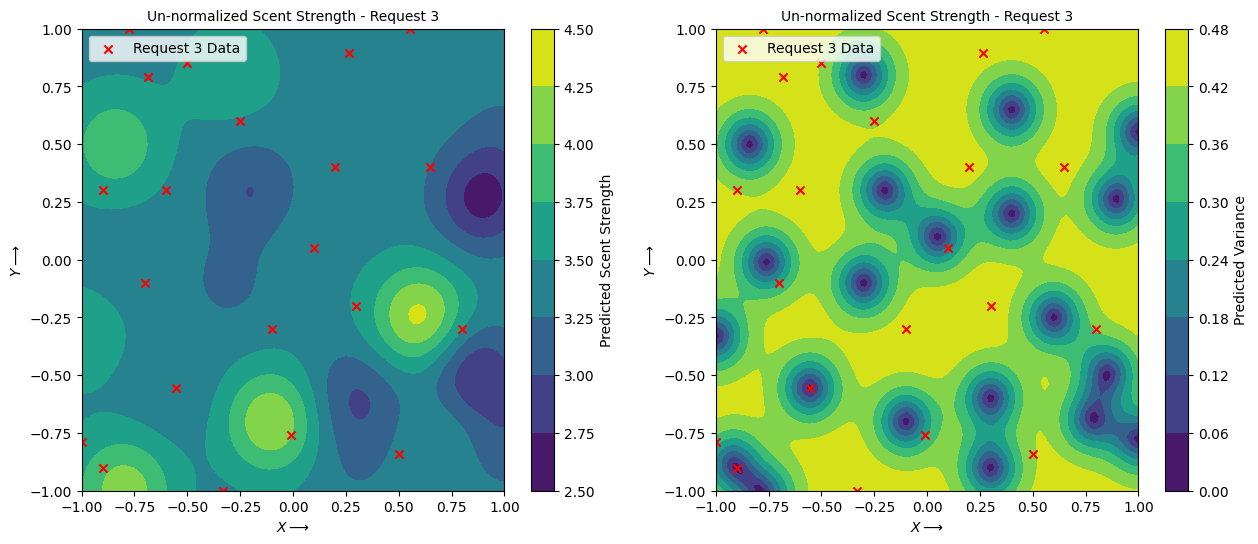

In [23]:
# after sampling request 1
S_req3 = non_normalized_scent_strength(y_predreq3, y_stdreq3, y_req3)

fig_req3, req3_axes = plot_gpr(xgprreq3, ygprreq3, X_req3, S_req3[0], S_req3[1], "Request 3 Data", "Un-normalized Scent Strength - Request 3")

# Final Burial Location - Uncertainty Quantification

In [24]:
def top_n_cost_points(mu, sigma, lam, x_gpr, y_gpr, n=5, epsilon=1e-6):

    # clip negai

    # Calculate the Confidence-Adjusted Inverse Mean cost for each location
    cost_matrix = 1/mu #(1 / (mu + epsilon)) * (1 + lam*sigma**2)

    # Flatten the cost matrix to find the top n values and their indices
    flat_costs = cost_matrix.flatten()
    flat_indices = np.argsort(flat_costs)[:20*n][::20]  # Get indices of top n highest costs

    # Convert flat indices back to 2D coordinates
    rows, cols = cost_matrix.shape
    top_n_locations = [(index // cols, index % cols) for index in flat_indices]
    top_n_costs = [flat_costs[index] for index in flat_indices]

    # Sort results in descending order
    top_n_costs, top_n_locations = zip(*sorted(zip(top_n_costs, top_n_locations), reverse=True))

    top_n_costs = np.array(top_n_costs)
    top_n_locations = np.array(top_n_locations)

    x_list = top_n_locations[:, 1]
    y_list = top_n_locations[:, 0]

    x_cord = x_gpr[x_list]
    y_cord = y_gpr[y_list]

    means = np.flip([np.round(mu[loc[0], loc[1]], 4) for loc in top_n_locations])
    stds = np.flip([np.round(sigma[loc[0], loc[1]], 4) for loc in top_n_locations])

    # vertically attach the x_cord and Y_cord
    top_n_locations = np.column_stack((x_cord, y_cord))

    return top_n_costs, top_n_locations, means, stds

Top Costs: [0.25569777 0.25542586 0.2550749  0.25439693 0.25374742 0.25309824]
Top Locations (row, col): [[-0.75757576  0.63636364]
 [-0.95959596 -0.85858586]
 [-0.81818182  0.63636364]
 [-0.8989899   0.57575758]
 [-0.85858586  0.49494949]
 [-0.83838384  0.55555556]]
Top Means [3.951  3.9409 3.9309 3.9204 3.915  3.9109]
Top Stds [0.0645 0.0233 0.1115 0.1546 0.0855 0.1717]


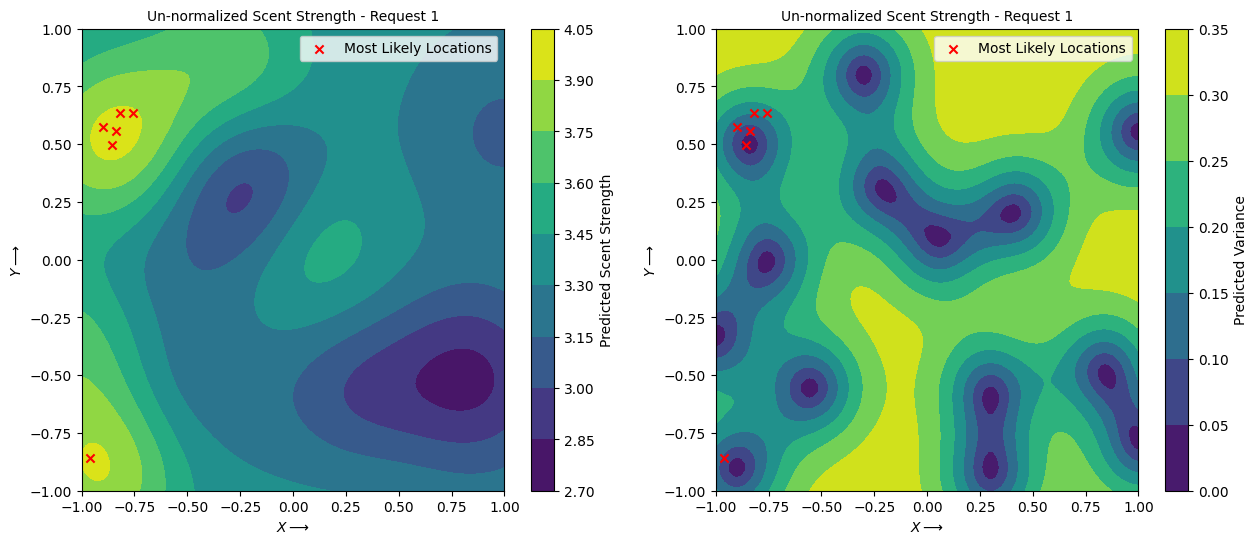

In [25]:
n = 6  # Number of top points to retrieve

top_costs_req1, top_locations_req1, means_req1, std_req1 = top_n_cost_points(S_req1[0], S_req1[1], 0.1, xgprreq1, ygprreq1, n)

# after sampling request 1
S_req1 = non_normalized_scent_strength(y_predreq1, y_stdreq1, y_req1)

fig_req1, req1_axes = plot_gpr(xgprreq1, ygprreq1, top_locations_req1, S_req1[0], S_req1[1], "Most Likely Locations", "Un-normalized Scent Strength - Request 1")

print("Top Costs:", top_costs_req1)
print("Top Locations (row, col):", top_locations_req1)
print("Top Means", means_req1)
print("Top Stds", std_req1)

Top Costs: [0.253762   0.25193418 0.24953744 0.24698739 0.24444451 0.24150027]
Top Locations (row, col): [[-0.83838384  0.53535354]
 [-0.85858586 -0.8989899 ]
 [-0.81818182 -0.8989899 ]
 [-0.6969697  -0.93939394]
 [-0.71717172 -0.95959596]
 [-0.77777778 -1.        ]]
Top Means [4.1408 4.0909 4.0488 4.0074 3.9693 3.9407]
Top Stds [0.0154 0.1328 0.1739 0.0975 0.0524 0.0617]


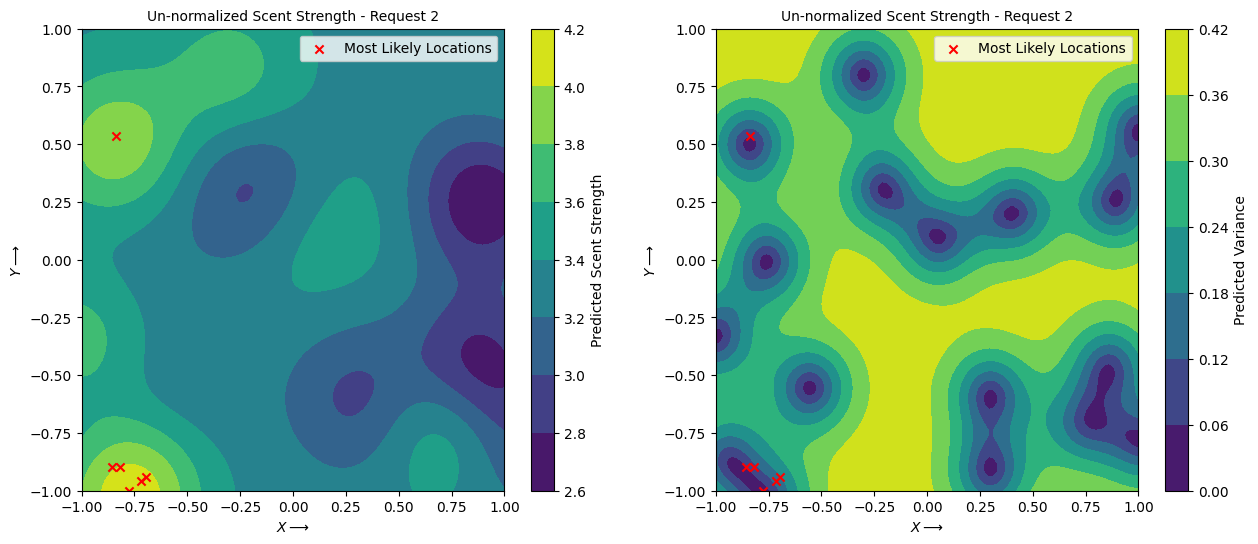

In [26]:
n = 6  # Number of top points to retrieve

top_costs_req2, top_locations_req2, means_req2, std_req2 = top_n_cost_points(S_req2[0], S_req2[1], 0.1, xgprreq2, ygprreq2, n)

# after sampling request 1
S_req2 = non_normalized_scent_strength(y_predreq2, y_stdreq2, y_req2)

fig_req2, req2_axes = plot_gpr(xgprreq2, ygprreq2, top_locations_req2, S_req2[0], S_req2[1], "Most Likely Locations", "Un-normalized Scent Strength - Request 2")

print("Top Costs:", top_costs_req2)
print("Top Locations (row, col):", top_locations_req2)
print("Top Means", means_req2)
print("Top Stds", std_req2)

Top Costs: [0.24182716 0.2408424  0.2394832  0.23819646 0.23623716 0.23342578]
Top Locations (row, col): [[ 0.67676768 -0.23232323]
 [-0.13131313 -0.75757576]
 [-0.09090909 -0.65656566]
 [-0.09090909 -0.67676768]
 [ 0.63636364 -0.21212121]
 [ 0.5959596  -0.23232323]]
Top Means [4.284  4.233  4.1982 4.1757 4.1521 4.1352]
Top Stds [0.052  0.1483 0.0719 0.1263 0.1823 0.2132]


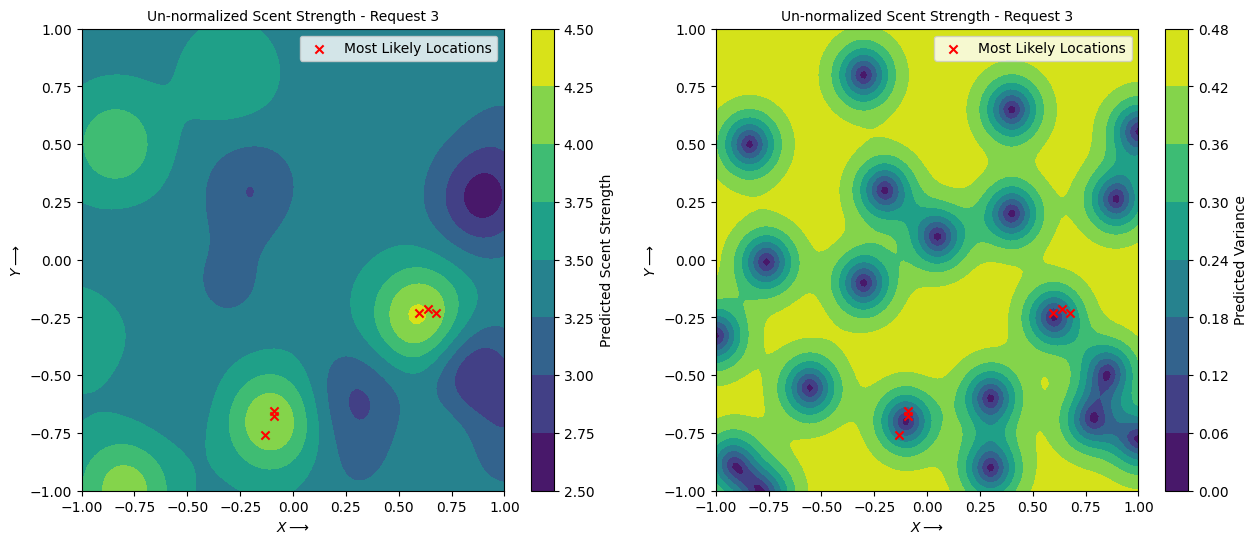

In [27]:
n = 6  # Number of top points to retrieve

top_costs_req3, top_locations_req3, means_req3, std_req3 = top_n_cost_points(S_req3[0], S_req3[1], 0.1, xgprreq3, ygprreq3, n)

# after sampling request 1
S_req3 = non_normalized_scent_strength(y_predreq3, y_stdreq3, y_req3)

fig_req3, req3_axes = plot_gpr(xgprreq3, ygprreq3, top_locations_req3, S_req3[0], S_req3[1], "Most Likely Locations", "Un-normalized Scent Strength - Request 3")

print("Top Costs:", top_costs_req3)
print("Top Locations (row, col):", top_locations_req3)
print("Top Means", means_req3)
print("Top Stds", std_req3)

# Find Credible Intervals

In [28]:
intervals = []
distance = []
for i in range(len(means_req3)):
  lower_bound = np.round(means_req3[i] - 1.96*std_req3[i], 4)
  upper_bound = np.round(means_req3[i] + 1.96*std_req3[i], 4)
  intervals.append([lower_bound, upper_bound])
  distance.append(np.round(upper_bound - lower_bound, 4))

print("Most Likely locations: ", top_locations_req3)
print("Standard Deviation: ", std_req3)
print("95% Credible Intervals ", intervals)
print("Interval length", distance)

Most Likely locations:  [[ 0.67676768 -0.23232323]
 [-0.13131313 -0.75757576]
 [-0.09090909 -0.65656566]
 [-0.09090909 -0.67676768]
 [ 0.63636364 -0.21212121]
 [ 0.5959596  -0.23232323]]
Standard Deviation:  [0.052  0.1483 0.0719 0.1263 0.1823 0.2132]
95% Credible Intervals  [[4.1821, 4.3859], [3.9423, 4.5237], [4.0573, 4.3391], [3.9282, 4.4232], [3.7948, 4.5094], [3.7173, 4.5531]]
Interval length [0.2038, 0.5814, 0.2818, 0.495, 0.7146, 0.8358]
